In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


2025-03-24 11:14:38.489987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742811278.537887    3798 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742811278.551590    3798 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742811278.659299    3798 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742811278.659344    3798 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742811278.659349    3798 computation_placer.cc:177] computation placer alr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from scipy import stats

## Ensure we are using GPU (if available)

In [19]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Step 1: Loading the dataset

In [5]:
path = "/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/2_Data_Processing/normalizing_data/normalized_data.csv"
data = pd.read_csv(path)

In [6]:
print(data.head())

   mainroad   parking  guestroom  airconditioning  semi-furnished  bathrooms  \
0  0.776377  1.955484  -0.344737         2.081257       -0.587296   1.669420   
1  0.776377  3.288479  -0.344737         2.081257       -0.587296   5.190194   
2  0.776377  1.955484  -0.344737        -0.480479        1.702720   1.669420   
3  0.776377  3.288479  -0.344737         2.081257       -0.587296   1.669420   
4  0.776377  1.955484   2.900761         2.081257       -0.587296  -0.090967   

   prefarea  bedrooms   stories      area  furnished  unfurnished  basement  \
0  2.491364  1.705365  1.680112  1.123354   2.351861    -0.511935 -0.520855   
1 -0.401386  1.705365  2.863209  1.896246   2.351861    -0.511935 -0.520855   
2  2.491364  0.377417  0.497014  2.398124  -0.425195    -0.511935  1.919922   
3  2.491364  1.705365  0.497014  1.163504   2.351861    -0.511935  1.919922   
4 -0.401386  1.705365  0.497014  1.123354   2.351861    -0.511935  1.919922   

   price_per_sqft  price_per_room  bath_to_b

## Step 2: Divide characteristics and objective variable

In [7]:

X = data.drop(columns=['price'])  # All collumns except 'price'
y = data['price']  # Objective variable

## Step 3: Divide by Training groups and test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 4: Normalize data

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 5: Build neural network model

In [10]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) 
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/environment/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742811497.719152    3798 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14284 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


## Step 6: Train the model 

In [15]:
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=8, validation_data=(X_test_scaled, y_test))

Epoch 1/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - mae: 0.0746 - val_loss: 0.0308 - val_mae: 0.1228
Epoch 2/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0619 - val_loss: 0.0274 - val_mae: 0.1196
Epoch 3/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0584 - val_loss: 0.0240 - val_mae: 0.1021
Epoch 4/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mae: 0.0452 - val_loss: 0.0228 - val_mae: 0.1005
Epoch 5/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - mae: 0.0377 - val_loss: 0.0226 - val_mae: 0.0990
Epoch 6/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - mae: 0.0361 - val_loss: 0.0262 - val_mae: 0.1065
Epoch 7/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mae: 0.0442 - val_loss: 0.0252 - val_mae: 0.1075
Epoch 8/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0574 - val_loss: 0.0280 - val_mae: 0.1130
Epoch 9/150
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

## Step 7: Evaluate Model

In [16]:
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'MAE: {mae}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - mae: 0.0881 
MAE: 0.08849915862083435


In [17]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R²: 0.9944250772007852


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Métricas de Entrenamiento:
MAE: 0.0404
RMSE: 0.0540
R²: 0.9990

Métricas de Prueba:
MAE: 0.0930
RMSE: 0.1369
R²: 0.9942


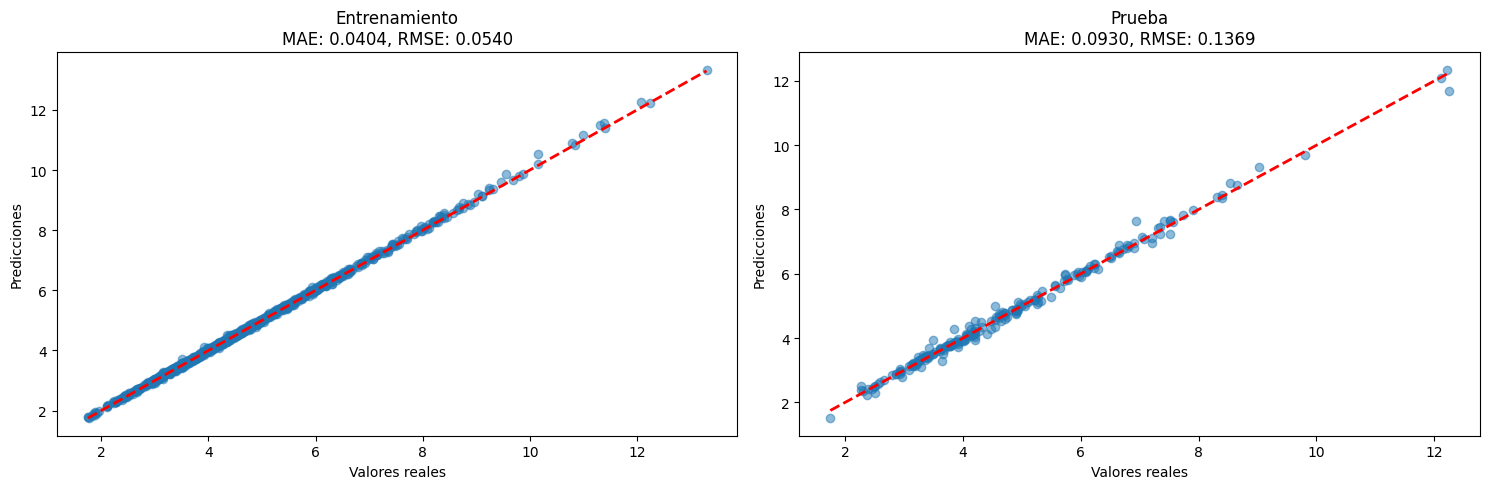

In [18]:

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calcular métricas
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Calcular el RMSE como porcentaje de la media de los datos de prueba
mean_value = np.mean(y_test)  # También puedes usar y_train si prefieres
rmse_percentage = (rmse_test / mean_value) * 100

# Imprimir métricas
print("\nMétricas de Entrenamiento:")
print(f'MAE: {mae_train:.4f}')
print(f'RMSE: {rmse_train:.4f}')
print(f'R²: {r2_train:.4f}')

print("\nMétricas de Prueba:")
print(f'MAE: {mae_test:.4f}')
print(f'RMSE: {rmse_test:.4f}')
print(f'R²: {r2_test:.4f}')

# Mostrar si el RMSE es superior al 15% de la media
if rmse_percentage > 15:
    print(f'El RMSE es superior al 15% de la media: {rmse_percentage:.2f}%')

# Visualización
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Entrenamiento\nMAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}')

plt.subplot(122)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Prueba\nMAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}')

plt.tight_layout()
plt.show()